# COVID Respiratory Modeling
In this notebook we will implement the mathematical model for viral particle deposition in the respiratory tract.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import fsolve

## Parameters
Values for the Airflow, Virus and Generation Characteristics. **Described in SI units.** 

In [2]:
# Airflow characteristics
rho_f = 1.2*10**(-3) # g cm^-3 #WRONG
mu = 1.81*10**(-4) # g cm^-1 s^-1
Q0 = 30 # L min^-1
g = 980 # cm s^-2
lamda = 0.066*10**(-4) # cm
K_b = 1.38*10**(-16) # cm^2 g s^-2 K^-1
T = 298 # K

# SI units:
rho_f = 1.2 # kg m^-3
mu = mu*0.1 # kg m^-1 s^-1 
Q0 = Q0*1.667*10**-5 # m^3 s^-1
g = g*0.01 #m s^-1
lamda = lamda*0.01 #m
K_b = K_b*10**-7 # m^2 kg s^-2 K^-1
T = T # K

In [3]:
# Virus characteristics
C0 = 10^7 # Copies/mL
# A = 
d_p = 60 # nm
#d_p = 130 # nm
rho_p = 1.18 # g cm^-3
p = 8.2 # day^-1
c = 0.6 # day^-1
b = 3.9*10**(-7) # (Copies/mL)^-1 day^-1
d = 4.71 # day^-1

# SI units: 

C0 = C0*10**6 # Copies/m^3
d_p = d_p*10**-9 # m
rho_p = rho_p*1000 # kg m^-3
p = p/86400 # s^-1
c = c/86400 # s^-1
b = b*10**-6/86400 # (Copies/m^3)^-1 s^-1
d = d/86400 # s^-1

In [4]:
# Generation characteristics
final_generation = 23

lengths = np.array([12, 4.76, 1.9, 1.76, 1.27, 1.07, 0.9, 0.76, 0.64, 0.54, 0.46, 0.39, 0.33, 0.27, 0.23, 0.2, 0.165, 0.14, 0.12, 0.099, 0.083, 0.07, 0.059, 0.05])
diameters = np.array([1.8, 1.22, 0.83, 0.56, 0.45, 0.35, 0.28, 0.23, 0.186, 0.154, 0.13, 0.109, 0.095, 0.082, 0.074, 0.061, 0.06, 0.054, 0.05, 0.047, 0.045, 0.043, 0.041, 0.04])

lengths_SI = [0.01*element for element in lengths]
diameters_SI = [0.01*element for element in diameters]

## 1. Fluid Velocity and Airflow Rate

In [5]:
def velocity(Q,d):
    A = np.pi*(d/2)**2
    u = Q/A
    return u

In [6]:
Q = {} #Dictionary for the flow rate
u = {} #Dictionary for the velocities
Q[0] = Q0
u[0] = velocity(Q0,diameters_SI[0])
for i in range(1,final_generation+1):
        Q[i] = Q[i-1]/2
        u[i] = velocity(Q[i],diameters_SI[i])
#print(u)

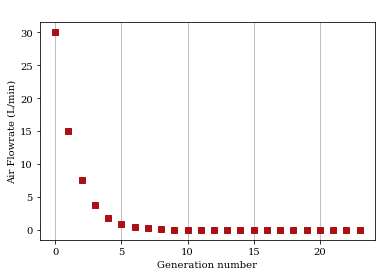

In [7]:
# PLOT AIRFLOW RATE

#Change Q to L min^-1
Q_paper = [60000*Q[i] for i in range(final_generation+1)]

sns.reset_orig()
sns.set_palette(sns.color_palette())
sns.set_color_codes()
sns.set_style({'font.family':'serif', 'font.serif':'Helvetica'})

reds = sns.color_palette("Reds")
reds.reverse()

fig_flow, ax_flow = plt.subplots()
ax_flow.set_title(" ")
ax_flow.set_ylabel("Air Flowrate (L/min)")
ax_flow.set_xlabel("Generation number")
#ax_flow.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=myhandles, labels=mylabels)
#ax_flow.set(xlim=(11.4, 4.6))
#ax_flow.set(ylim=(50, 95))
ax_flow.xaxis.grid()

final_colors = [reds[0]]
final_lines = ['-']
final_markers = ['s']
final_labels = ["label"]
for i in range(final_generation+1):
    ax_flow.plot(i, Q_paper[i], color=final_colors[0],
                 marker=final_markers[0], label=final_labels[0],
                 linestyle=final_lines[0])   
#fig_flow.savefig(os.path.join(outputdir, "Pressure_along_path_600dpi"), bbox_inches='tight', dpi=600)

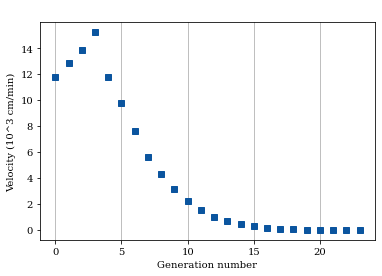

In [251]:
# PLOT VELOCITY

#Change u to 10^3 cm min^-1
u_paper = [6*u[i] for i in range(final_generation+1)]


sns.reset_orig()
sns.set_palette(sns.color_palette())
sns.set_color_codes()
sns.set_style({'font.family':'serif', 'font.serif':'Helvetica'})

blues = sns.color_palette("Blues")
blues.reverse()

fig_flow, ax_flow = plt.subplots()
ax_flow.set_title(" ")
ax_flow.set_ylabel("Velocity (10^3 cm/min)")
ax_flow.set_xlabel("Generation number")
#ax_flow.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=myhandles, labels=mylabels)
#ax_flow.set(xlim=(11.4, 4.6))
#ax_flow.set(ylim=(50, 95))
ax_flow.xaxis.grid()

final_colors = [blues[0]]
final_lines = ['-']
final_markers = ['s']
final_labels = ["label"]
for i in range(final_generation+1):
    ax_flow.plot(i, u_paper[i], color=final_colors[0],
                 marker=final_markers[0], label=final_labels[0],
                 linestyle=final_lines[0])   
#fig_flow.savefig(os.path.join(outputdir, "Pressure_along_path_600dpi"), bbox_inches='tight', dpi=600)

## 2. Deposition
Impaction, Sedimentation and Diffusion

In [9]:
# Functions

C_c = 1 + (2*lamda/d_p)*(1.257+0.4*np.exp(-1.1*d_p/(2*lamda)))

def impaction(L,d,u):
    k_I = (1.3*rho_p*d_p**2*u)/(L*18*mu*d)
    return k_I

def beta_sedimentation(L,d,u):
    B = (3*np.pi*L*u_g)/(16*u*d)
    return B

def sedimentation(L,d,Q,u):
    B = beta_sedimentation(L,d,u)
    k_S = ((2*Q)/(np.pi*L)) * (2*B*np.sqrt(1-B**(2/3)) - B**(1/3)*np.sqrt(1-B**(2/3)) + np.arcsin(B**(1/3))) 
    return k_S

def diffusivity(d_p):
    D = (K_b*T)/(3*np.pi*mu*d_p)
    #D = C_c*(K_b*T)/(3*np.pi*mu*d_p)
    return D

def beta_diffusion(L,Q):
    D = diffusivity(d_p)
    B = np.pi*D*L/(4*Q)
    return B

def diffusion(L,Q):
    B = beta_diffusion(L,Q)
    k_d = (1 - 0.819*np.exp(-14.63*B) - 0.0976*np.exp(-89.22*B) - 0.0325*np.exp(-228*B) - 0.0509*np.exp(-125.9*B**(2/3)))
    return k_d


4.299146980547118


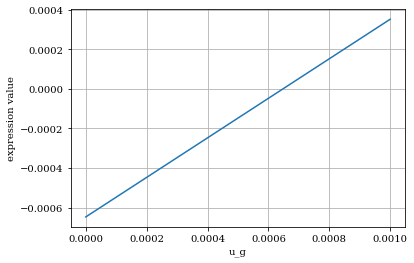

The solution is u_g = 0.000648
at which the value of the expression is 0.000000
The solution for a simpler u_g = 0.000001


In [10]:
#Re_p = rho_f*u_g*d_p/mu
#C_D = (24/Re_p)*(1 + 0.15*Re_p**0.687)
#C_c = 1 + (2*lamda/d_p)*(1.257+0.4*np.exp((-1.1*d_p)/(2*lamda)))

#func = lambda u_g : - u_g - (4*C_c*d_p**2*rho_p*(rho_p-rho_f)*g)/(3*mu*C_D*Re_p*rho_f)
#func = lambda u_g : u_g - (4*(1 + (2*lamda/d_p)*(1.257+0.4*np.exp((-1.1*d_p)/(2*lamda))))*d_p**2*rho_p*(rho_p-rho_f)*g)/(3*mu*((24/(rho_f*u_g*d_p/mu))*(1 + 0.15*(rho_f*u_g*d_p/mu)**0.687))*(rho_f*u_g*d_p/mu)*rho_f)

C_c = 1 + (2*lamda/d_p)*(1.257+0.4*np.exp(-1.1*d_p/(2*lamda)))
print(C_c)
func = lambda u_g : u_g - (4*C_c*d_p**2*rho_p*(rho_p-rho_f)*g)/(3*mu*24*(1+0.15*(rho_f*u_g*d_p/mu)**(0.687)))

# Plot it

x_axes = np.linspace(0, 0.001, 201)

plt.plot(x_axes, func(x_axes))
plt.xlabel("u_g")
plt.ylabel("expression value")
plt.grid()
plt.show()

# Use the numerical solver to find the roots

u_g_initial_guess = 0.5
u_g = fsolve(func, u_g_initial_guess)

print("The solution is u_g = %f" % u_g)
print("at which the value of the expression is %f" % func(u_g))

# Check with the other paper's formula

simple_u_g = C_c*rho_p*g*d_p**2/(18*mu)
print("The solution for a simpler u_g = %f" % simple_u_g)

In [11]:
# Find deposition for each generation

k_I = {}
k_s = {}
k_d = {}
for i in range(0,final_generation+1):
        k_I[i] = impaction(lengths_SI[i],diameters_SI[i],u[i])
        if (beta_sedimentation(lengths_SI[i],diameters_SI[i],u[i]))>1 :
            beta = beta_sedimentation(lengths_SI[i],diameters_SI[i],u[i])
            print('ERROR: in generation %d with beta %f bigger than one' %(i,beta) )
            print(lengths_SI[i])
            print(diameters_SI[i])
            print(u[i])
            print(u_g)
            k_s[i] = 0
        else:
            k_s[i] = sedimentation(lengths_SI[i],diameters_SI[i], Q[i], u[i])
        k_d[i] = diffusion(lengths_SI[i],Q[i])



ERROR: in generation 23 with beta 1.005024 bigger than one
0.0005
0.0004
0.0004744135561004691
[0.00064755]


In [12]:
print(lengths_SI[23])
print(diameters_SI[23])

0.0005
0.0004


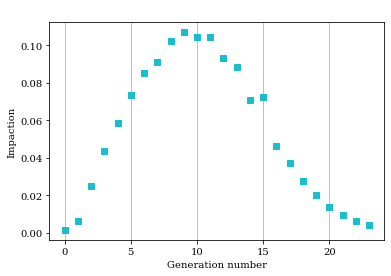

In [261]:
# PLOT IMPACTION

#Change k_I to cm^-1
k_I_newunits = [100*k_I[i] for i in range(final_generation+1)]

sns.reset_orig()
sns.set_palette(sns.color_palette())
sns.set_color_codes()
sns.set_style({'font.family':'serif', 'font.serif':'Helvetica'})

set1 = sns.color_palette()
set1.reverse()

fig_flow, ax_flow = plt.subplots()
ax_flow.set_title(" ")
#ax_flow.set_ylabel("Impaction (cm-1)")
ax_flow.set_ylabel("Impaction")
ax_flow.set_xlabel("Generation number")
#ax_flow.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=myhandles, labels=mylabels)
#ax_flow.set(xlim=(11.4, 4.6))
#ax_flow.set(ylim=(50, 95))
ax_flow.xaxis.grid()

final_colors = [set1[0]]
final_lines = ['-']
final_markers = ['s']
final_labels = ["label"]
for i in range(final_generation+1):
    ax_flow.plot(i, k_I_newunits[i], color=final_colors[0],
                 marker=final_markers[0], label=final_labels[0],
                 linestyle=final_lines[0])   
#fig_flow.savefig(os.path.join(outputdir, "Pressure_along_path_600dpi"), bbox_inches='tight', dpi=600)

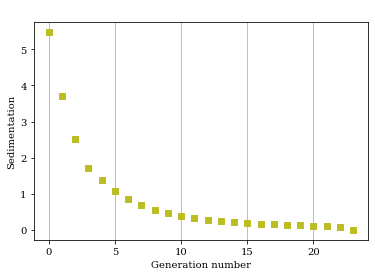

In [263]:
# PLOT SEDIMENTATION

#Change k_s to cm^2/min
k_s_newunits = [600000*k_s[i] for i in range(final_generation+1)]

sns.reset_orig()
sns.set_palette(sns.color_palette())
sns.set_color_codes()
sns.set_style({'font.family':'serif', 'font.serif':'Helvetica'})

set1 = sns.color_palette()
set1.reverse()

fig_flow, ax_flow = plt.subplots()
ax_flow.set_title(" ")
#ax_flow.set_ylabel("k_s (cm2/min)")
ax_flow.set_ylabel("Sedimentation")
ax_flow.set_xlabel("Generation number")
#ax_flow.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=myhandles, labels=mylabels)
#ax_flow.set(xlim=(11.4, 4.6))
#ax_flow.set(ylim=(50, 95))
ax_flow.xaxis.grid()

final_colors = [set1[1]]
final_lines = ['-']
final_markers = ['s']
final_labels = ["label"]
for i in range(final_generation+1):
    ax_flow.plot(i, k_s_newunits[i], color=final_colors[0],
                 marker=final_markers[0], label=final_labels[0],
                 linestyle=final_lines[0])   
#fig_flow.savefig(os.path.join(outputdir, "Pressure_along_path_600dpi"), bbox_inches='tight', dpi=600)

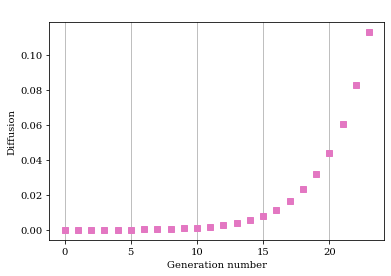

In [264]:
# PLOT DIFFUSION

sns.reset_orig()
sns.set_palette(sns.color_palette())
sns.set_color_codes()
sns.set_style({'font.family':'serif', 'font.serif':'Helvetica'})

set1 = sns.color_palette()
set1.reverse()

fig_flow, ax_flow = plt.subplots()
ax_flow.set_title(" ")
ax_flow.set_ylabel("Diffusion")
ax_flow.set_xlabel("Generation number")
#ax_flow.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=myhandles, labels=mylabels)
#ax_flow.set(xlim=(11.4, 4.6))
#ax_flow.set(ylim=(50, 95))
ax_flow.xaxis.grid()

final_colors = [set1[3]]
final_lines = ['-']
final_markers = ['s']
final_labels = ["label"]
for i in range(final_generation+1):
    ax_flow.plot(i, k_d[i], color=final_colors[0],
                 marker=final_markers[0], label=final_labels[0],
                 linestyle=final_lines[0])   
#fig_flow.savefig(os.path.join(outputdir, "Pressure_along_path_600dpi"), bbox_inches='tight', dpi=600)

## 3. Adjust deposition to paper values

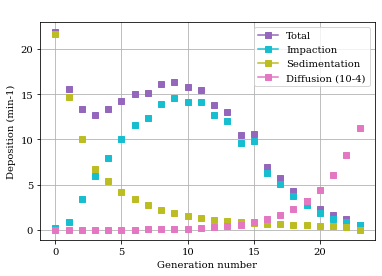

In [273]:
# Change the depositions rates to match the paper values

k_I_conv_factor = 10/0.07352 # cm/min
k_I_paper = [k_I_conv_factor*k_I_newunits[i] for i in range(final_generation+1)]

k_s_conv_factor =  10/2.529 # cm^-2
k_s_paper = [k_s_conv_factor*k_s_newunits[i] for i in range(final_generation+1)]

k_d_conv_factor = 1/100 #min^-1
k_d_paper = [k_d_conv_factor*k_d[i] for i in range(final_generation+1)]
k_d_paper_e4 = [10000*k_d_paper[i] for i in range(final_generation+1)]



sns.reset_orig()
sns.set_palette(sns.color_palette())
sns.set_color_codes()
sns.set_style({'font.family':'serif', 'font.serif':'Helvetica'})

blues = sns.color_palette("Blues")
blues.reverse()
reds = sns.color_palette("Reds")
reds.reverse()
greens = sns.color_palette("Greens")
greens.reverse()

set1 = sns.color_palette()
set1.reverse()


fig_flow, ax_flow = plt.subplots()
ax_flow.set_title(" ")
ax_flow.set_ylabel("Deposition (min-1)")
ax_flow.set_xlabel("Generation number")
#ax_flow.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=myhandles, labels=mylabels)
#ax_flow.set(xlim=(11.4, 4.6))
#ax_flow.set(ylim=(50, 95))
ax_flow.xaxis.grid()
ax_flow.yaxis.grid()


final_colors = set1
final_lines = ['-']
final_markers = ['s']
final_labels = ["label"]
k_paper = {}
for i in range(final_generation+1):
    k_paper[i] = k_I_paper[i] + k_s_paper[i] + k_d_paper[i]
    ax_flow.plot(i, k_paper[i], color=final_colors[5],
                 marker=final_markers[0], label=final_labels[0],
                 linestyle=final_lines[0])
    ax_flow.plot(i, k_I_paper[i], color=final_colors[0],
                 marker=final_markers[0], label=final_labels[0],
                 linestyle=final_lines[0])  
    ax_flow.plot(i, k_s_paper[i], color=final_colors[1],
                 marker=final_markers[0], label=final_labels[0],
                 linestyle=final_lines[0])  
    ax_flow.plot(i, k_d_paper_e4[i], color=final_colors[3],
                 marker=final_markers[0], label=final_labels[0],
                 linestyle=final_lines[0])

plt.legend(loc='upper right', labels=['Total', 'Impaction', 'Sedimentation', 'Diffusion (10-4)'])

#fig_flow.savefig(os.path.join(outputdir, "Pressure_along_path_600dpi"), bbox_inches='tight', dpi=600)

## 4. Obtain the concentration profile

In [17]:
from scipy.integrate import quad

def integrand(x, const1, const2):
    return const1*np.exp(const2*x)
  
def concentration(C_previous, i):
    #C = ((u[i]*C_previous)/(u[i]+np.sqrt(u[i]**2+4*D*(k-p)))) * np.exp( (u[i]-np.sqrt(u[i]**2+4*D(k-p))*x)/(2*D) )
    D = diffusivity(d_p)
    const1 = (u[i]*C_previous) / (u[i]+np.sqrt(u[i]**2+4*D*(k_paper[i]-p)))
    const2 = (u[i]-np.sqrt(u[i]**2+4*D*(k_paper[i]-p))) / (2*D)
    I = quad(integrand, 0, lengths_SI[i], args=(const1,const2))
    C = I[0]/lengths_SI[i]
    return C

C = {}
C[0] = C0
for i in range(1,final_generation+1):
        C[i] = concentration(C[i-1], i)

C

{0: 13000000,
 1: 5495482.763652123,
 2: 2602015.3403263343,
 3: 1245442.9195176663,
 4: 596622.0324283772,
 5: 284772.36092496215,
 6: 135084.18449281532,
 7: 63566.31917877626,
 8: 29603.06767772731,
 9: 13620.127852795098,
 10: 6181.779941663524,
 11: 2759.9454442863575,
 12: 1212.616288369848,
 13: 522.8371397902338,
 14: 221.62177741951317,
 15: 91.0991125477094,
 16: 37.07346520376477,
 17: 14.727638740287897,
 18: 5.713703728181738,
 19: 2.1640564812958822,
 20: 0.7976382545904483,
 21: 0.28440936179779186,
 22: 0.09770443597873232,
 23: 0.03708449289131958}

## 5. Viral dynamics

In [274]:
from scipy.integrate import odeint

In [275]:
C_ml = [10**(-6)*C[i] for i in range(final_generation+1)]
b_days_ml = b*86400*10**6 # (Copies/mL)^-1 day^-1
b_days_m3 = b*86400 # (Copies/m^3)^-1 day^-1
p_days = p*86400 # day^-1
c_days = c*86400
d_days = d*86400


In [276]:
def dynamics(x,t): 
    dx = [0,0,0]
    dx[0] = -b_days_ml*x[0]*x[2]
    dx[1] = b_days_ml*x[0]*x[2] - d_days*x[1]
    dx[2] = p_days*x[1] -c_days*x[2]
    return dx

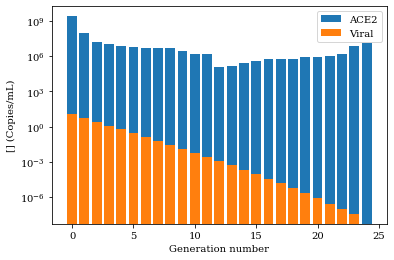

In [291]:
# ACE2 concentrations in Copies/mL
A = [9.419354838709676, 8, 7.225806451612902, 7.041474654377879, 6.9308755760368665, 6.783410138248847, 6.746543778801843, 6.709677419354839, 6.6728110599078345, 6.433179723502303, 6.211981566820276, 6.193548387096774, 5.050691244239632, 5.216589861751152, 5.400921658986175, 5.585253456221198, 5.788018433179723, 5.8433179723502295, 5.8433179723502295, 5.880184331797234, 5.935483870967742, 5.953917050691244, 6.24884792626728, 6.857142857142856, 7.059907834101382]
A = np.round(A,1)
A = [10**A[i] for i in range(len(A))]


plt.bar(range(len(A)), A)
plt.yscale('log')

# Virus concentrations in Copies/mL
plt.bar(range(final_generation+1), C_ml)
plt.yscale('log')
plt.ylabel('[] (Copies/mL)')
plt.xlabel('Generation number')

plt.legend(loc='upper right', labels=['ACE2', 'Viral'])




Text(0.5, 0, 'Generation number')

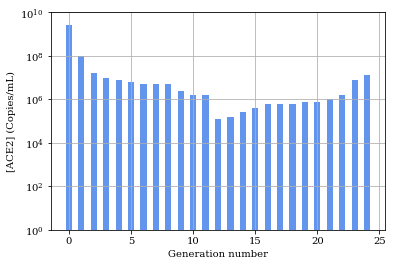

In [318]:
plt.bar(range(len(A)), A, width=0.5, color='cornflowerblue')
plt.yscale('log')
plt.ylabel('[ACE2] (Copies/mL)')
plt.ylim(1,10**10)
plt.grid()
plt.xlabel('Generation number')


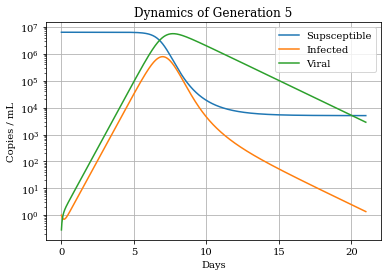

In [358]:
t = np.arange( 0., 21., 0.01)
j = 5
A0 = A[j]
C0 = C_ml[j]
x =[A0,1,C0]

N = odeint(dynamics, x, t)
#N = np.round(N)
plt.plot(t,N)
plt.title('Dynamics of Generation {}'.format(j))
plt.ylabel('Copies / mL')
plt.xlabel('Days')
plt.grid()
plt.legend(['Supsceptible','Infected','Viral'])
plt.yscale("log")
plt.show()

In [247]:
susceptible = {}
infected = {}
viral = {}
t = t = np.arange( 0., 60, 1)

for i in range(1,final_generation+1):
    x = [A[i],0,C_ml[i]]
    N = odeint(dynamics, x, t)
    #N = np.round(N)
    
    susceptible[i] = (N[:,0])
    infected[i] = (N[:,1])
    viral[i] = (N[:,2])

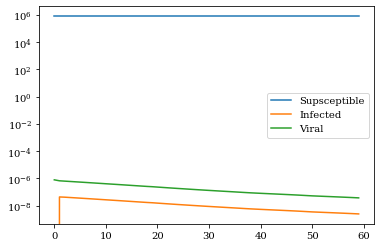

In [250]:

j = 20
N = np.transpose([susceptible[j],infected[j],viral[j]])
plt.plot(t,N)
plt.legend(['Supsceptible','Infected','Viral'])
plt.yscale("log")
plt.show()

<ipython-input-230-eed9334e5a01>:25: RuntimeWarning: invalid value encountered in log10
  Z[i,j] = np.log10(viral[i][j])
<ipython-input-230-eed9334e5a01>:29: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(X, Y, Z)


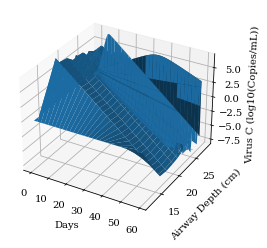

In [230]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
from matplotlib import cm
import random


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

t = t = np.arange( 0., 60, 1)
X = t #days
Y = np.zeros(len(lengths))
Y[0] = lengths[0]
for i in range(1,len(lengths)):
    #print(i)
    Y[i] = Y[i-1] + lengths[i]


Z = np.zeros((len(Y), len(X)))

for i in range(1,final_generation+1):
    for j in range(1,len(t)):
        Z[i,j] = np.log10(viral[i][j])

X, Y = np.meshgrid(X, Y)

ax.plot_surface(X, Y, Z)



ax.set_xlabel('Days')
ax.set_ylabel('Airway Depth (cm)')
ax.set_zlabel('Virus C (log10(Copies/mL))')
ax.set_zlim(-8, 7)


plt.show()


In [228]:
print(Z.shape)
print(X.shape)
print(Y.shape)

(24, 60)
(24, 60)
(24, 60)


In [197]:
t = t = np.arange( 0., 60, 1)
X = t #days
Y = np.zeros(len(lengths))
Y[0] = lengths[0]
for i in range(1,len(lengths)):
    #print(i)
    Y[i] = Y[i-1] + lengths[i]


Z = np.zeros((len(Y), len(X)))

X, Y = np.meshgrid(X, Y)


print(Z.shape)
print(X.shape)
print(Y.shape)


(24, 60)
(24, 60)
(24, 60)


In [172]:
Z.shape

(120, 120)

## Results for modified conditions

In [336]:
Q0_mod = [15, 30, 45, 60] #L/min

Q0_mod_SI = [1.667e-5*element for element in Q0_mod] #m^3/s

labels = ['Q0 = 15 L/min', 'Q0 = 30 L/min', 'Q0 = 45 L/min', 'Q0 = 60 L/min']

In [345]:
# GET u_g

C_c = 1 + (2*lamda/d_p)*(1.257+0.4*np.exp(-1.1*d_p/(2*lamda)))
print(C_c)
func = lambda u_g : u_g - (4*C_c*d_p**2*rho_p*(rho_p-rho_f)*g)/(3*mu*24*(1+0.15*(rho_f*u_g*d_p/mu)**(0.687)))

# Use the numerical solver to find the roots

u_g_initial_guess = 0.5
u_g = fsolve(func, u_g_initial_guess)

print("The solution is u_g = %f" % u_g)
print("at which the value of the expression is %f" % func(u_g))

# Check with the other paper's formula

simple_u_g = C_c*rho_p*g*d_p**2/(18*mu)
print("The solution for a simpler u_g = %f" % simple_u_g)

4.299146980547118
The solution is u_g = 0.000648
at which the value of the expression is 0.000000
The solution for a simpler u_g = 0.000001


ERROR: in generation 22 with beta 1.215577 bigger than one
0.00059
0.00041000000000000005
0.0004515536524454197
[0.00064755]
ERROR: in generation 23 with beta 2.010049 bigger than one
0.0005
0.0004
0.00023720677805023454
[0.00064755]
ERROR: in generation 23 with beta 1.005024 bigger than one
0.0005
0.0004
0.0004744135561004691
[0.00064755]


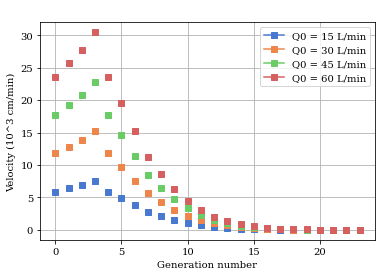

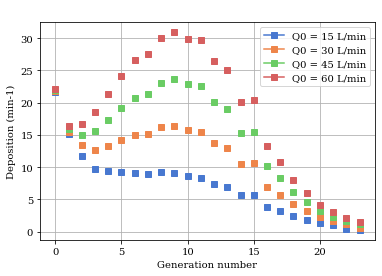

In [351]:
# Calculate and Plot Velocity and Deposition
sns.reset_orig()
sns.set_palette(sns.color_palette())
sns.set_color_codes()
sns.set_style({'font.family':'serif', 'font.serif':'Helvetica'})

set2 = sns.color_palette("muted")
#set2.reverse()


fig_u, ax_u = plt.subplots()
fig_k, ax_k = plt.subplots()

ax_u.set_title(" ")
ax_u.set_ylabel("Velocity (10^3 cm/min)")
ax_u.set_xlabel("Generation number")


ax_k.set_title(" ")
ax_k.set_ylabel("Deposition (min-1)")
ax_k.set_xlabel("Generation number")
#ax_flow.set(xlim=(11.4, 4.6))
#ax_flow.set(ylim=(50, 95))

ax_u.xaxis.grid()
ax_u.yaxis.grid()
ax_k.xaxis.grid()
ax_k.yaxis.grid()

final_colors = set2
final_lines = ['-']
final_markers = ['s']
final_labels = labels


for j in range(0,len(Q0_mod_SI)):
    
    Q = {} #Dictionary for the flow rate
    u = {} #Dictionary for the velocities
    Q[0] = Q0_mod_SI[j]
    u[0] = velocity(Q[0],diameters_SI[0])
    for i in range(1,final_generation+1):
            Q[i] = Q[i-1]/2
            u[i] = velocity(Q[i],diameters_SI[i])

    # PLOT VELOCITY

    #Change u to 10^3 cm min^-1
    u_paper = [6*u[i] for i in range(final_generation+1)]

 
    for i in range(final_generation+1):
        if i == 0:
            ax_u.plot(i, u_paper[i], color=final_colors[j],
                         marker=final_markers[0], label=final_labels[j],
                         linestyle=final_lines[0])   
        else :
            ax_u.plot(i, u_paper[i], color=final_colors[j],
                         marker=final_markers[0])   
    
    # PLOT DEPOSITION
    
    k_I = {}
    k_s = {}
    k_d = {}
    for i in range(0,final_generation+1):
            k_I[i] = impaction(lengths_SI[i],diameters_SI[i],u[i])
            if (beta_sedimentation(lengths_SI[i],diameters_SI[i],u[i]))>1 :
                beta = beta_sedimentation(lengths_SI[i],diameters_SI[i],u[i])
                print('ERROR: in generation %d with beta %f bigger than one' %(i,beta) )
                print(lengths_SI[i])
                print(diameters_SI[i])
                print(u[i])
                print(u_g)
                k_s[i] = 0
            else:
                k_s[i] = sedimentation(lengths_SI[i],diameters_SI[i], Q[i], u[i])
            k_d[i] = diffusion(lengths_SI[i],Q[i])
    k_I_newunits = [100*k_I[i] for i in range(final_generation+1)]
    k_s_newunits = [600000*k_s[i] for i in range(final_generation+1)]
    
    k_I_conv_factor = 10/0.07352 # cm/min
    k_I_paper = [k_I_conv_factor*k_I_newunits[i] for i in range(final_generation+1)]

    k_s_conv_factor =  10/2.529 # cm^-2
    k_s_paper = [k_s_conv_factor*k_s_newunits[i] for i in range(final_generation+1)]

    k_d_conv_factor = 1/100 #min^-1
    k_d_paper = [k_d_conv_factor*k_d[i] for i in range(final_generation+1)]
    k_d_paper_e4 = [10000*k_d_paper[i] for i in range(final_generation+1)]

    k_paper = {}
    for i in range(final_generation+1):
        k_paper[i] = k_I_paper[i] + k_s_paper[i] + k_d_paper[i]
        if i == 0:
            ax_k.plot(i, k_paper[i], color=final_colors[j],
                         marker=final_markers[0], label=final_labels[j],
                         linestyle=final_lines[0])   
        else :
            ax_k.plot(i, k_paper[i], color=final_colors[j],
                         marker=final_markers[0]) 


            

ax_u.legend()
ax_k.legend()
